In [1]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import keras_tuner as kt

In [2]:
IMGAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 70

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_images",
    shuffle=True,
    image_size = (IMGAGE_SIZE, IMGAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 10407 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

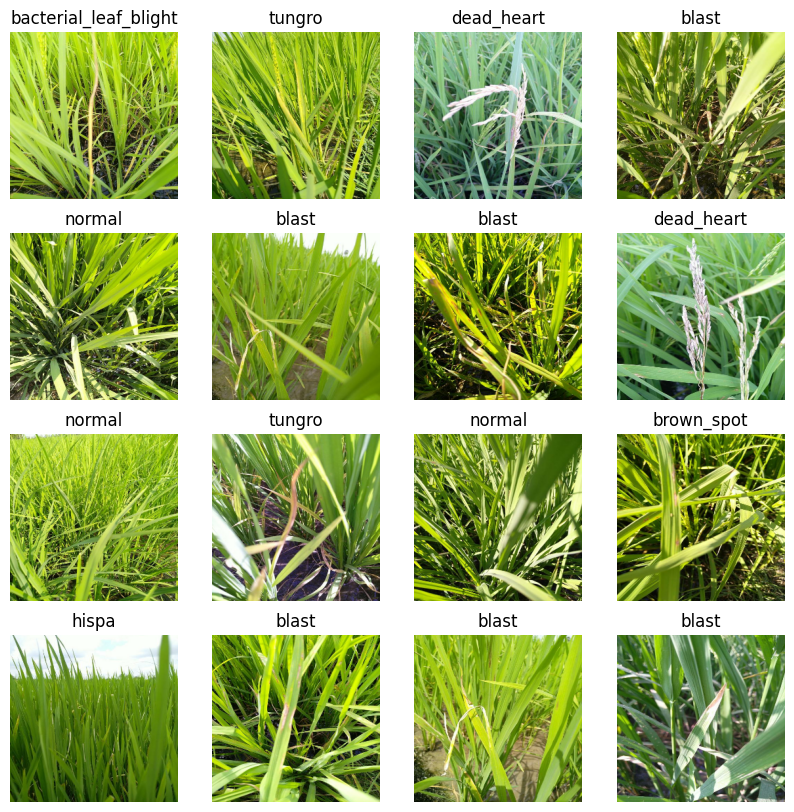

In [5]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    plt.show()

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split = 0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [7]:
from tensorflow.python.client import device_lib
import tensorflow as tf

# List all physical GPU devices
gpus = tf.config.list_physical_devices('GPU')
print("Available GPU devices:")
for gpu in gpus:
    print(gpu)

# More detailed device info
print("\nDetailed device info:")
print(device_lib.list_local_devices())


Available GPU devices:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Detailed device info:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10306641858307449144
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18290929890689817714
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [8]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(val_ds), len(test_ds)

(260, 32, 34)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMGAGE_SIZE, IMGAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.Resizing(IMGAGE_SIZE, IMGAGE_SIZE),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.Rescaling(1./255)  # Do rescale last to keep image values valid
])


In [11]:

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))


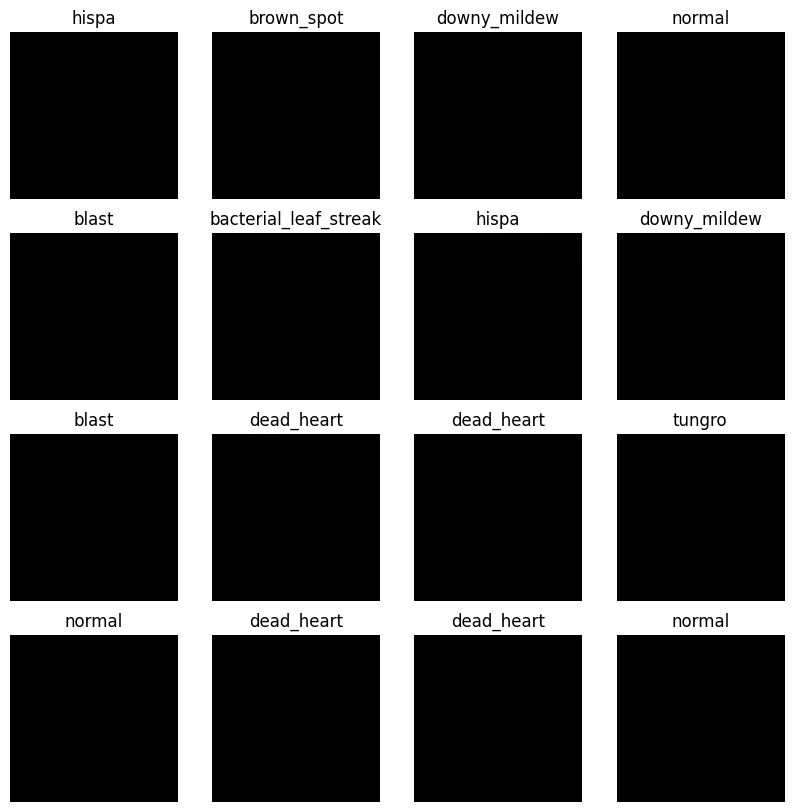

In [12]:
for image_batch, label_batch in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    plt.show()

In [13]:
input_shape = (IMGAGE_SIZE, IMGAGE_SIZE, CHANNELS)
n_classes = 10
def build_model(hp, input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    # Fixed Conv blocks (as you already found effective)
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # 🔧 Tune dropout rate
    model.add(layers.Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))

    model.add(layers.Dense(n_classes, activation='softmax'))

    # 🔧 Tune learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.RandomSearch(
    lambda hp: build_model(hp, input_shape, n_classes),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning'
)

In [14]:
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, input_shape, n_classes),
    objective='val_accuracy',
    max_trials=6,
    executions_per_trial=1,
    directory='kt_logs',
    project_name='tune_lr_dropout'
)

Reloading Tuner from kt_logs\tune_lr_dropout\tuner0.json


In [15]:
tuner.search(train_ds, validation_data=val_ds, epochs=5)

In [16]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_hp.values

{'dropout': 0.2, 'learning_rate': 0.001}

In [17]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
best_model = build_model(best_hp, input_shape, n_classes)

# Retrain longer with best settings
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,

)


Epoch 1/70
260/260 [==============================] - 52s 159ms/step - loss: 1.9164 - accuracy: 0.3261 - val_loss: 1.9557 - val_accuracy: 0.3018
Epoch 2/70
260/260 [==============================] - 34s 116ms/step - loss: 1.5636 - accuracy: 0.4565 - val_loss: 1.6828 - val_accuracy: 0.4062
Epoch 3/70
260/260 [==============================] - 38s 132ms/step - loss: 1.3876 - accuracy: 0.5219 - val_loss: 4.6532 - val_accuracy: 0.2227
Epoch 4/70
260/260 [==============================] - 43s 151ms/step - loss: 1.2469 - accuracy: 0.5720 - val_loss: 1.6984 - val_accuracy: 0.4665
Epoch 5/70
260/260 [==============================] - 43s 149ms/step - loss: 1.1468 - accuracy: 0.6156 - val_loss: 1.2021 - val_accuracy: 0.6074
Epoch 6/70
260/260 [==============================] - 43s 148ms/step - loss: 1.0782 - accuracy: 0.6345 - val_loss: 1.8109 - val_accuracy: 0.4922
Epoch 7/70
260/260 [==============================] - 39s 134ms/step - loss: 0.9551 - accuracy: 0.6811 - val_loss: 0.7353 - val_ac

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

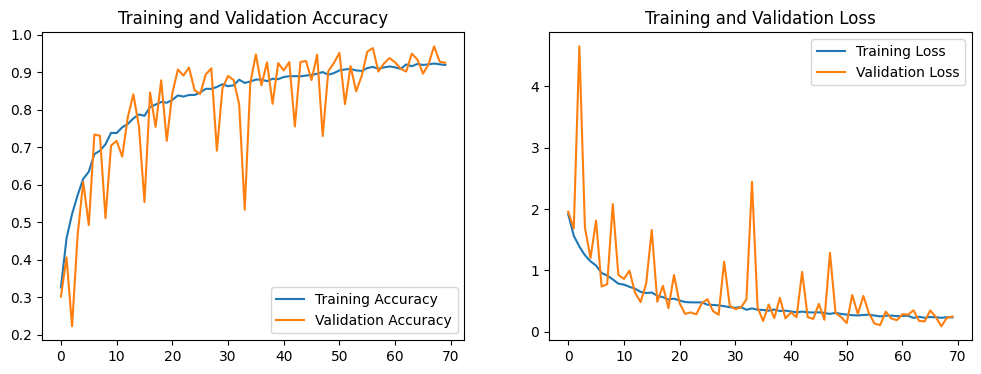

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"🧪 Test Loss: {test_loss:.4f}")


34/34 [==============================] - 5s 21ms/step - loss: 0.2845 - accuracy: 0.9072
✅ Test Accuracy: 0.9072
🧪 Test Loss: 0.2845


In [21]:
from keras.models import load_model
best_model.save('best_model.h5')